In [1]:
!conda install -c conda-forge folium=0.5.0 --yes # comment/uncomment if not yet installed.
!conda install -c conda-forge geopy --yes        # comment/uncomment if not yet installed

import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library
from sklearn.preprocessing import StandardScaler #we are going to use this to find the optimal k for clustering
from sklearn.metrics import silhouette_score #once again when finding the optimal k

import requests # library to handle requests
import bs4 as bs
import urllib.request

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    ------------------------------------------------------------
                       

In [2]:
url   = "https://en.wikipedia.org/wiki/List_of_districts_of_Istanbul"

In [107]:
from IPython.display import HTML
import base64

# Extra Helper scripts to generate download links for saved dataframes in csv format.
def create_download_link( df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

page  = urllib.request.urlopen(url).read()
soup  = bs.BeautifulSoup(page,'lxml')
table = soup.find("table",class_="wikitable")
header = [head.findAll(text=True)[0].strip() for head in table.find_all("th")]
data   = [[td.findAll(text=True)[0].strip() for td in tr.find_all("td")]
          for tr in table.find_all("tr")]
data    = [row for row in data if len(row) == 6] #I have 6 columns

raww_df= pd.DataFrame(data,columns=header)
raww_df.to_csv('istanbul_district_income_density_population_area.csv',index=False)

raw_df = pd.DataFrame(data,columns=header)
raw_df = raw_df[:-4] #removing last 4 rows of unneccessary info.
raw_df = raw_df.drop(raw_df.columns[[4,5]], axis=1) #removing last 2 columns of unneccessary info.
raw_df = raw_df.replace(',','', regex=True) #removing commas from numbers
raw_df['Population (2019)'].astype(str).astype(float)
raw_df['Area (km²)'].astype(str).astype(float)
raw_df['Density (per km²)'].astype(str).astype(float) #converting from string to float
raw_df=raw_df.sort_values(by=['District','Population (2019)','Area (km²)','Density (per km²)'], ascending=[1,1,1,1]).reset_index(drop=True)

print(raw_df.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 4 columns):
District             39 non-null object
Population (2019)    39 non-null object
Area (km²)           39 non-null object
Density (per km²)    39 non-null object
dtypes: object(4)
memory usage: 1.3+ KB
None


In [108]:
create_download_link(raww_df,"Istanbul District List 2019(income_density_population_area)","istanbul_district_income_density_population_area_2019.csv")

In [109]:
create_download_link(raw_df,"Istanbul District List 2019(population_area_density)","istanbul_district_population_area_density_2019")

In [117]:
raw_df.head()

,District,Population (2019),Area (km²),Density (per km²)
0,Adalar,15238,11.05,1379
1,Arnavutköy,282488,450.35,627
2,Ataşehir,425094,25.23,16849
3,Avcılar,448882,42.01,10685
4,Bahçelievler,611059,16.62,36766


In [118]:
geolocator = Nominatim(user_agent='My-IBMNotebook')
lokasyon=[]
lat=[]
lon=[]
for x in range(0, len(raw_df)):#some district names like Şile gets mistaken for Chile so we add Istanbul next to them.
    lokasyon.append(raw_df.loc[x,'District']+', Istanbul')
for r in range(0, len(raw_df)):
    location = geolocator.geocode(lokasyon[r])
    lat.append(location.latitude)
    lon.append(location.longitude)

In [119]:
map(float, lat)#converting to float
map(float, lon)
raw_df = raw_df.assign(Latitude = lat) #adding lat and lon values for districts
raw_df = raw_df.assign(Longitude = lon)
raw_df = raw_df.drop(raw_df.columns[[1,2,3]], axis=1) #should've done this earlier, but firmly decided not to use population now, so, off they go.

In [120]:
raw_df.head()

,District,Latitude,Longitude
0,Adalar,40.876259,29.091027
1,Arnavutköy,41.184182,28.740729
2,Ataşehir,40.984749,29.106720
3,Avcılar,40.980135,28.717547
4,Bahçelievler,41.000290,28.863745


In [121]:
raw_df.to_csv('istanbul_district_latlon.csv',index=False) #storing into a csv for proper use, whatever that means.

In [122]:
create_download_link(raw_df,"Istanbul District List 2019(district_lat_lon)","istanbul_district_latlon.csv")

In [123]:
ist = pd.read_csv('istanbul_district_latlon.csv')

In [10]:
#getting the coordinates for Istanbul for map creation
address = 'Istanbul Turkey'

locationist = geolocator.geocode(address)
latitudist = locationist.latitude
longitudist = locationist.longitude
print('The geograpical coordinates for Istanbul are {}, {}.'.format(latitudist, longitudist))

The geograpical coordinates for Istanbul are 41.0096334, 28.9651646.


In [11]:
#creating a map of Istanbul with Districts
map_istanbul = folium.Map(location=[latitudist, longitudist], zoom_start=10)

# add markers to map
for lat, lng, label in zip(ist['Latitude'], ist['Longitude'], ist['District']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#87cefa',
        fill_opacity=0.5,
    ).add_to(map_istanbul)
map_istanbul

I have foursquare API credentials in the cell below so I am hiding it:
CLIENT_ID = 'your_id' 
CLIENT_SECRET = 'your_secret' 
VERSION = '20180604'
LIMIT = your_limit_value

In [12]:
# The code was removed by Watson Studio for sharing.

In [13]:

# Get the venue names and store it in a dataframe
def getNearbyVenues(names, latitudes, longitudes, radius=20000):#20km radius to filter every possible option since we are dealing with districts.
                                                                #Since we also deal with islands 20km is overkill, but would give an idea anyway.
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # creating API request url
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [14]:
ist_venues=getNearbyVenues(names=ist['District'], latitudes=ist['Latitude'],longitudes=ist['Longitude'])

In [15]:
#filtering results with parks only
ist_park=ist_venues[ist_venues['Venue Category'].str.contains('Park')]
#and forests
ist_orman=ist_venues[ist_venues['Venue Category'].str.contains('Forest')] 
#and gardens
ist_bahce=ist_venues[ist_venues['Venue Category'].str.contains('Garden')] 
#and dogruns eventghough you may not be a dog person
ist_dog=ist_venues[ist_venues['Venue Category'].str.contains('Dog')] 
#and farms considering they are places that you can refresh
ist_cift=ist_venues[ist_venues['Venue Category'].str.contains('Farm')] 
#and parkours where you can take a walk that may be alongside a greenspace
ist_parkur=ist_venues[ist_venues['Venue Category'].str.startswith('Field')]
#I am pushin the boundaries and counting mountain tops as green spaces too.
ist_dag=ist_venues[ist_venues['Venue Category'].str.contains('Mountain')] 
#In the context of green spaces, cemeteries are also in the mix, but I assume no one would go to a cemetery to get a breath of fresh air.

ist_green=ist_park #creating a dataframe where all of them are listed.
ist_green=ist_green.append(ist_orman)
ist_green=ist_green.append(ist_bahce)
ist_green=ist_green.append(ist_dag)
ist_green=ist_green.append(ist_cift)
ist_green=ist_green.append(ist_dog)
ist_green=ist_green.append(ist_parkur)

In [16]:
#reseting the indexing for the dataframe
ist_green=ist_green.sort_values(by=['District','District Latitude','District Longitude','Venue','Venue Latitude','Venue Longitude','Venue Category'], ascending=[1,1,1,1,1,1,1]).reset_index(drop=True)

In [17]:
ist_green.to_csv('istanbul_greenspaces.csv',index=False) #storing into a csv for proper use, whatever that means.

In [125]:
ist_green.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adalar,40.876259,29.091027,50. Yıl Korusu,40.941546,29.123211,Park
1,Adalar,40.876259,29.091027,Aşıklar Tepesi,40.860718,29.113596,Mountain
2,Adalar,40.876259,29.091027,Büyükada Tepesi,40.861107,29.117418,Mountain
3,Adalar,40.876259,29.091027,Caddebostan - Fenerbahçe Yürüyüş Yolu,40.969874,29.052894,Park
4,Adalar,40.876259,29.091027,Fenerbahçe Parkı,40.968483,29.035801,Park


In [126]:
create_download_link(ist_green,"Istanbul District List 2019(district_nearbygreen20km_venue_lat_lon)","istanbul_greenspaces.csv")

In [18]:
print('There are {} unique venues.'.format(len(ist_green['Venue'].unique()))) #No of unique green spaces

There are 33 unique venues.


In [19]:
#lets see the map where these greens are located
for lat, lng, label in zip(ist_green['Venue Latitude'], ist_green['Venue Longitude'], ist_green['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='green',
        fill=True,
        fill_color='#87cefa',
        fill_opacity=0.5,
    ).add_to(map_istanbul)
map_istanbul

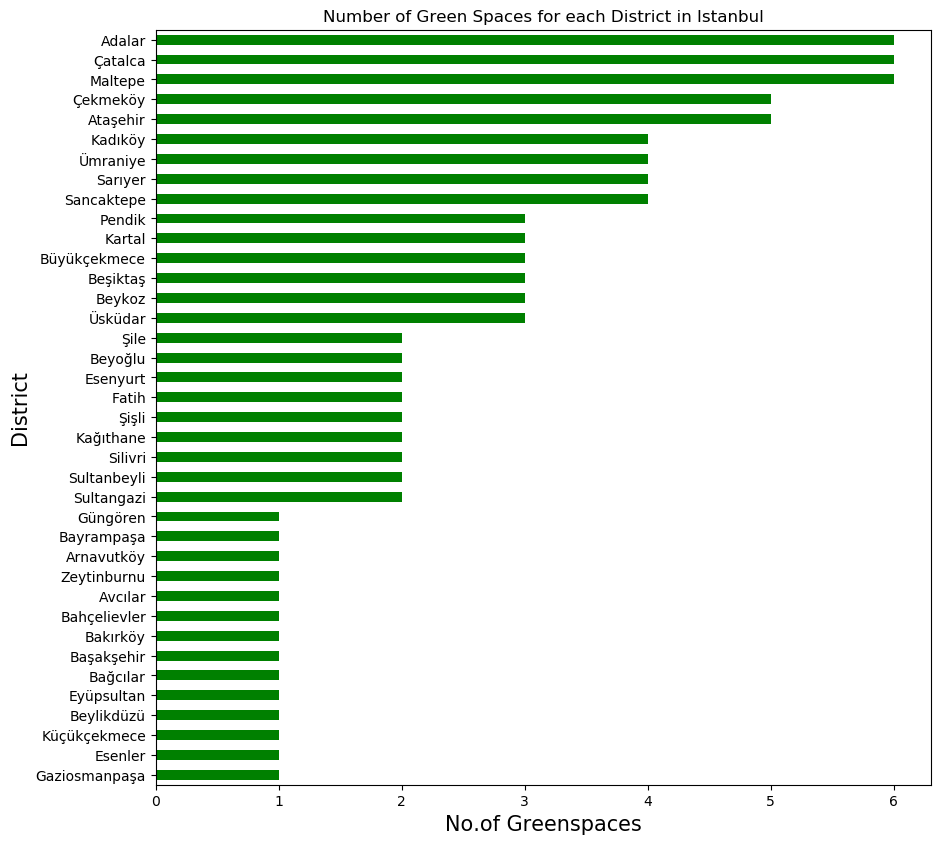

In [20]:
#The venues are not unique to their respective districts, lets see which district has more greenspace.

plt.figure(figsize=(10,10), dpi = 100)
plt.title('Number of Green Spaces for each District in Istanbul')
#On x-axis
plt.xlabel('No.of Greenspaces', fontsize = 15)
#On y-axis
plt.ylabel('District Name', fontsize=15)
#giving a bar plot
ist_green.groupby('District')['Venue'].count().sort_values(ascending=True).plot(kind='barh',color='green')
#displays the plot
plt.show()

In [ ]:
#We can see from our graph that Adalar, Çatalca and Maltepe are the most green Districts
#While a total of 11 districts from Gaziosmanpaşa and Güngören are the least green.

In [21]:
# one hot encoding
ist_onehot = pd.get_dummies(ist_green[['Venue Category']], prefix="", prefix_sep="")

# add district column back to dataframe
ist_onehot['District'] = ist_green['District'] 

# move district column to the first column
fixed_columns = [ist_onehot.columns[-1]] + list(ist_onehot.columns[:-1])
ist_onehot = ist_onehot[fixed_columns]

# Regroup rows by district and mean of frequency occurrence per category.
ist_grouped = ist_onehot.groupby('District').mean().reset_index()

In [22]:
ist_grouped.to_csv('istanbul_greenspaces_freq_district.csv',index=False) #storing into a csv for proper use, whatever that means.

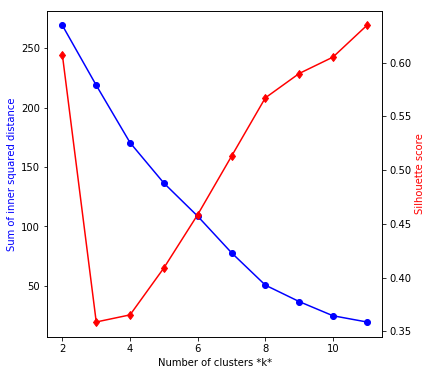

In [71]:
#lets check the optimal value of k we should use in order to obtain ideal clustering
ist_grouped_clustering =ist_grouped.drop('District', 1)
ist_std = StandardScaler().fit_transform(ist_grouped_clustering)
sse = []
sil = []
list_k = list(range(2, 12))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(ist_std)
    sse.append(km.inertia_)
    sil.append(silhouette_score(ist_std, km.labels_))

fig, ax1 = plt.subplots(figsize=(6, 6))

ax2 = ax1.twinx()
ax1.plot(list_k, sse, 'bo-')
ax2.plot(list_k, sil, 'rd-')

ax1.set_xlabel(r'Number of clusters *k*')
ax1.set_ylabel('Sum of inner squared distance', color='b')
ax2.set_ylabel('Silhouette score', color='r')

plt.show()

In [59]:
# We can see k=6 is best.
kclusters = 6
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(ist_grouped_clustering)
# check cluster labels generated for each row in the dataframe
print(kmeans.labels_[0:10])

[4 5 1 0 0 0 1 0 0 2]


In [60]:
ist_sorted = ist.set_index("District")
ist_merged = ist_grouped.set_index("District")
ist_merged['Cluster Labels'] = kmeans.labels_
ist_merged = ist_merged.join(ist_sorted)

In [99]:
# creating the map for clusters
map_clusters = folium.Map(location=[latitudist, longitudist], tiles="Openstreetmap", zoom_start=10)


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ist_merged['Latitude'], ist_merged['Longitude'], ist_merged.index.values,kmeans.labels_):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)   
map_clusters

In [100]:
ist_merged.loc[ist_merged['Cluster Labels'] == 0, ist_merged.columns[[2] + list(range(0, ist_merged.shape[1]))]]
#The cluster where there is access to a forest.

,Farm,Botanical Garden,Dog Run,Farm,Field,Forest,Garden,Mountain,National Park,Park,Cluster Labels,Latitude,Longitude
District,,,,,,,,,,,,,
Avcılar,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,40.980135,28.717547
Bahçelievler,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,41.000290,28.863745
Bakırköy,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,40.983541,28.867973
Bağcılar,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,41.033899,28.857898
Başakşehir,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,41.097693,28.806163
Güngören,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,41.022871,28.872629
Küçükçekmece,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,41.000214,28.780889


In [92]:
ist_merged.loc[ist_merged['Cluster Labels'] == 1, ist_merged.columns[[2] + list(range(0, ist_merged.shape[1]))]]
#The cluster where there is only access to mainly a Park and a Field

,Farm,Botanical Garden,Dog Run,Farm,Field,Forest,Garden,Mountain,National Park,Park,Cluster Labels,Latitude,Longitude
District,,,,,,,,,,,,,
Ataşehir,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.8,1,40.984749,29.106720
Bayrampaşa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,41.035738,28.912260
Beyoğlu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,41.028423,28.973681
Esenler,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,41.033254,28.890953
Eyüpsultan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,41.046044,28.925324
Fatih,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,41.009633,28.965165
Gaziosmanpaşa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,41.057526,28.915650
Kadıköy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,40.991572,29.027017
Kağıthane,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,41.085980,28.972621


In [93]:
ist_merged.loc[ist_merged['Cluster Labels'] == 2, ist_merged.columns[[2] + list(range(0, ist_merged.shape[1]))]]
#The the cluster where there is every category but a mountain top

,Farm,Botanical Garden,Dog Run,Farm,Field,Forest,Garden,Mountain,National Park,Park,Cluster Labels,Latitude,Longitude
District,,,,,,,,,,,,,
Beykoz,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.333333,0.0,0.000000,0.666667,2,41.123935,29.108315
Beşiktaş,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.333333,0.0,0.000000,0.666667,2,41.042847,29.007528
Büyükçekmece,0.000000,0.333333,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.333333,0.333333,2,41.015691,28.595524
Esenyurt,0.000000,0.500000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.500000,2,41.034240,28.680018
Sancaktepe,0.250000,0.000000,0.000000,0.250000,0.250000,0.00,0.000000,0.0,0.000000,0.500000,2,40.996887,29.236601
Sarıyer,0.000000,0.250000,0.000000,0.000000,0.000000,0.25,0.250000,0.0,0.000000,0.250000,2,41.168592,29.056649
Silivri,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.500000,0.0,0.000000,0.500000,2,41.073204,28.246922
Sultanbeyli,0.000000,0.000000,0.000000,0.000000,0.500000,0.00,0.000000,0.0,0.000000,0.500000,2,40.968087,29.258789
Sultangazi,0.000000,0.000000,0.000000,0.000000,0.000000,0.50,0.000000,0.0,0.000000,0.500000,2,41.109240,28.882614


In [94]:
ist_merged.loc[ist_merged['Cluster Labels'] == 3, ist_merged.columns[[2] + list(range(0, ist_merged.shape[1]))]]
#The the cluster where there is only access to a Botanical Garden

,Farm,Botanical Garden,Dog Run,Farm,Field,Forest,Garden,Mountain,National Park,Park,Cluster Labels,Latitude,Longitude
District,,,,,,,,,,,,,
Beylikdüzü,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,41.001026,28.641984


In [95]:
ist_merged.loc[ist_merged['Cluster Labels'] == 4, ist_merged.columns[[2] + list(range(0, ist_merged.shape[1]))]]
#The the cluster where there is access to a mountain top, field and a park

,Farm,Botanical Garden,Dog Run,Farm,Field,Forest,Garden,Mountain,National Park,Park,Cluster Labels,Latitude,Longitude
District,,,,,,,,,,,,,
Adalar,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.333333,0.0,0.666667,4,40.876259,29.091027
Kartal,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.666667,0.0,0.333333,4,40.888492,29.189602
Maltepe,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.333333,0.0,0.500000,4,40.923542,29.132836
Pendik,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.666667,0.0,0.333333,4,40.876589,29.233342


In [96]:
ist_merged.loc[ist_merged['Cluster Labels'] == 5, ist_merged.columns[[2] + list(range(0, ist_merged.shape[1]))]]
#The the cluster where there is access to a garden.

,Farm,Botanical Garden,Dog Run,Farm,Field,Forest,Garden,Mountain,National Park,Park,Cluster Labels,Latitude,Longitude
District,,,,,,,,,,,,,
Arnavutköy,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5,41.184182,28.740729


In [73]:
#We can understand from the clusters that the most variety of green spaces are in cluster2
#And the least variety is in cluster 3 and 5 districts Beylikdüzü and Arnavutköy

In [ ]:
#From our clustering map and bar graph consisting the access to number of green spaces
#the ideal district for green space variety and quantity would be Çatalca.
#The least ideal would either be Arnavutköy or Beylikdüzü since they only have access to
#a single botanical garden and a garden.